# Single Integral Comparisons 2
*David Thomas 2017/03/27*

After fixing a bug that surfaced in the previous single integral comparisons we seek to retest our method.

# Setup

In [197]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rc
from bigmali.grid import Grid
from bigmali.likelihood import BiasedLikelihood
from bigmali.prior import TinkerPrior
from bigmali.hyperparameter import get
from scipy.stats import lognorm
from time import time
rc('text', usetex=True)

data = pd.read_csv('/Users/user/Code/PanglossNotebooks/MassLuminosityProject/mock_data.csv')
data.ix[0]

true_mass = 1.005246e+11
true_z = 2.077090e+00
true_lum = 1.377704e+04
true_lum_obs = 1.374879e+04
true_lum_obs_collection = data.lum_obs

prior = TinkerPrior(Grid())

def p1(lobs, lum, sigma):
    return fast_lognormal(lum, sigma, lobs)

def p2(lum, mass, a1, a2, a3, a4, S, z):
    mu_lum = np.exp(a1) * ((mass / a3) ** a2) * ((1 + z) ** (a4))
    return fast_lognormal(mu_lum, S, lum)
    
def p3(mass, z):
    return prior.fetch(z).pdf(mass)

def q1(lum, lobs, sigma):
    return fast_lognormal(lobs, sigma, lum)
    
def q2(mass, lum, a1, a2, a3, a4, S, z):
    mu_mass = a3 * (lum / (np.exp(a1) * (1 + z) ** a4)) ** (1 / a2)
    return fast_lognormal(mu_mass, S, mass)

def midpoints(arr):
    n = len(arr)-1
    ret = np.zeros(n)
    for i in xrange(n):
        ret[i] = (arr[i+1] + arr[i]) / 2.
    return ret

def fast_lognormal(mu, sigma, x):
    return  (1/(x * sigma * np.sqrt(2 * np.pi))) * np.exp(- 0.5 * (np.log(x) - np.log(mu)) ** 2 / sigma ** 2)

a1,a2,a3,a4,S = get()

In [198]:
p2(space, true_mass, a1, a2, a3, a4, S, true_z)

10275.5266333


array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [100]:
fast_lognormal(1,1,1)

0.3989422804014327

In [101]:
fast_lognormal(1,2,1)

0.19947114020071635

In [102]:
fast_lognormal(1,np.array([1,2]),1)

array([ 0.39894228,  0.19947114])

Sanity check that distributions we use all integrate to 1.

In [196]:
from scipy.integrate import trapz

space = np.linspace(true_lum_obs_collection.min(), true_lum_obs_collection.max(), 10**5)
pp1 = p1(space,true_lum, 0.05)
print trapz(pp1, space)

space = np.linspace(true_lum_obs_collection.min(), true_lum_obs_collection.max(), 10**5)
pp2 = p2(space, true_mass, a1, a2, a3, a4, S, true_z)
print trapz(pp2, space)

space = np.linspace(data.mass.min(), data.mass.max(), 10**4)
pp3 = p3(space, true_z)
print trapz(pp3, space)

space = np.linspace(true_lum_obs_collection.min(), true_lum_obs_collection.max(), 10**5)
qq1 = q1(true_lum, space, 0.05)
print trapz(qq1, space)

space = np.linspace(data.mass.min(), data.mass.max(), 10**4)
qq2 = q2(space, true_lum, a1, a2, a3, a4, S, true_z)
print trapz(qq2, space)

1.0
10275.5266333
1.0
1.07420251604
1.00125078158
1.0


Check lognorm and fast_lognormal behaves as expected

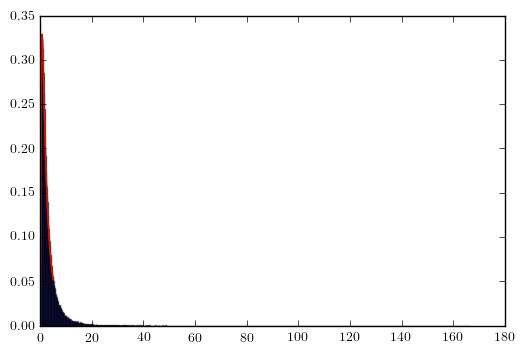

In [121]:
r = lognorm(1,scale=2).rvs(size=10**5)
plt.hist(r, normed=True, bins=1000, alpha=0.5)
space = np.linspace(0.1,5,100)
pspace = lognorm(1,scale=2).pdf(space)
plt.plot(space, pspace)
fspace = fast_lognormal(2,1,space)
plt.plot(space, fspace)

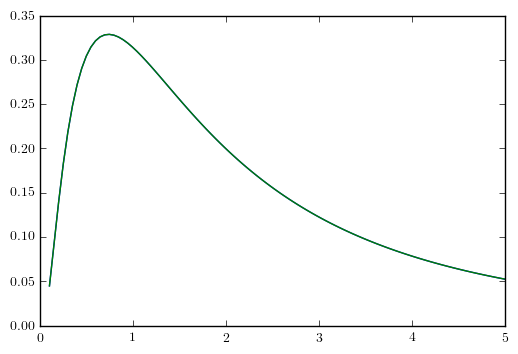

In [122]:
space = np.linspace(0.1,5,100)
pspace = lognorm(1,scale=2).pdf(space)
plt.plot(space, pspace)
fspace = fast_lognormal(2,1,space)
plt.plot(space, fspace)

In [59]:
print pp1

[  0.00000000e+000   4.01861087e-004   1.78221822e-036   1.55154287e-091
   2.04711608e-147   1.65835619e-200   2.98359648e-250   8.54311716e-297
   0.00000000e+000   0.00000000e+000]


In [58]:
pp1

array([  0.00000000e+000,   4.01861087e-004,   1.78221822e-036,
         1.55154287e-091,   2.04711608e-147,   1.65835619e-200,
         2.98359648e-250,   8.54311716e-297,   0.00000000e+000,
         0.00000000e+000])

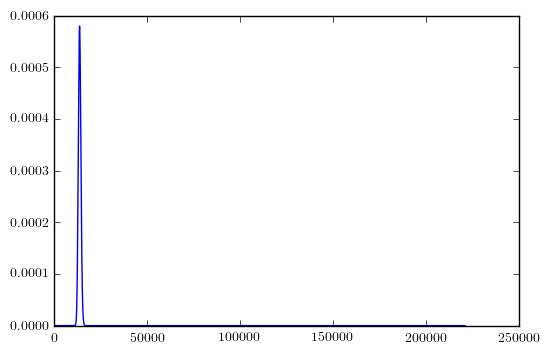

In [47]:
plt.plot(space, pp1)

# Numerical Integration

\begin{align*}
\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs}, z) &= \iint\ dLdM\ P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)\\
&= \sum_{M=min(MP)}^{max(MP)}\sum_{L = min(L_{obs})}^{max(L_{obs})}\ \Delta_M\Delta_L\ P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)\\
\end{align*}

In [155]:
def numerical_integration_grid(a1, a2, a3, a4, S):
    nsamples = 100
    masses = midpoints(prior.fetch(true_z).mass[1:-1])
    delta_masses = np.diff(prior.fetch(true_z).mass[1:-1])
    lums_tmp = np.logspace(log10(np.min(data.lum_obs)), log10(np.max(data.lum_obs)), nsamples)
    lums = midpoints(lums_tmp)
    delta_lums = np.diff(lums_tmp)
    sigma = 0.05
    integral = 0
    ans = np.zeros((len(lums)*len(masses),3))
    count = 0
    for i, lum in enumerate(lums):
        for j, mass in enumerate(masses):
            ans[count,0] = lum
            ans[count,1] = mass
            ans[count,2] = np.sum(delta_masses[j] * delta_lums[i] * p1(true_lum_obs, lum, sigma) * \
            p2(lum, mass, a1, a2, a3, a4, S, true_z) * p3(mass, true_z))
            count += 1
    return ans

In [156]:
grid = numerical_integration_grid(a1,a2,a3,a4,S)

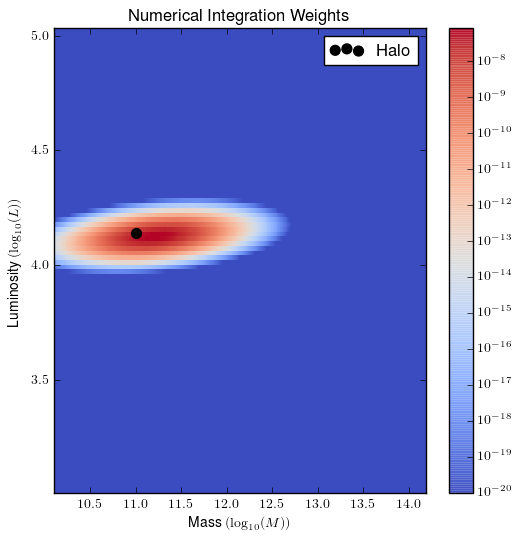

In [159]:
import matplotlib.colors as colors
step = 1
epsilon = 1e-20
gridv = np.maximum(grid[::step,2], epsilon)
x = log10(grid[::step,0])
y = log10(grid[::step,1])
scat = plt.scatter(y, x, marker='s', s=40, alpha=0.8, c=gridv, norm=colors.LogNorm(), cmap='coolwarm', lw=0);
plt.gcf().set_size_inches((6,6))
plt.ylim([x.min(),x.max()])
plt.xlim([y.min(),y.max()])
plt.scatter(log10(true_mass), log10(true_lum_obs), color='black', s=50, label='Halo')
# plt.scatter(x[22723], y[22723], color='gold', s=50, label='MaximumWeight')
plt.legend()
plt.gcf().colorbar(scat)
plt.title('Numerical Integration Weights')
plt.xlabel('Mass $(\log_{10}(M))$')
plt.ylabel('Luminosity $(\log_{10}(L))$')

In [469]:
nsamples = np.logspace(1, 5, 10)
times = []
res = []

for ns in nsamples:
    start = time()
    res.append(numerical_integration(a1,a2,a3,a4,S,nsamples=ns))
    end = time()
    times.append(end-start)

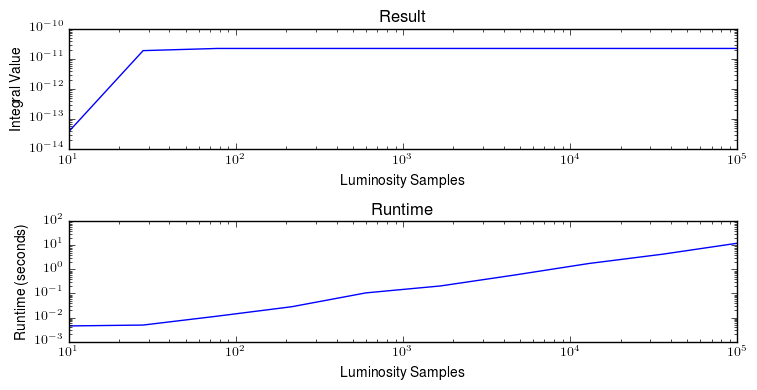

In [480]:
plt.subplot(211)
plt.title('Result')
plt.plot(nsamples, res)
plt.ylabel('Integral Value')
plt.xlabel('Luminosity Samples')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.subplot(212)
plt.title('Runtime')
plt.plot(nsamples, times)
plt.ylabel('Runtime (seconds)')
plt.xlabel('Luminosity Samples')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.tight_layout()
plt.gcf().set_size_inches((8,4))

Note: stability even with different hyperparameters.

In [510]:
%time numerical_integration(a1,a2,a3,a4,S_test,nsamples=100)

CPU times: user 15.9 ms, sys: 1.31 ms, total: 17.2 ms
Wall time: 16.4 ms


1.6392239694116272e-05

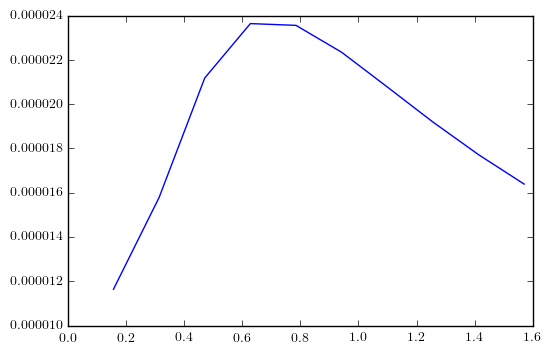

In [38]:
S_space = S * np.linspace(1,10, 10)
vals = []
for S_test in S_space:
    vals.append(numerical_integration(a1,a2,a3,a4,S_test,nsamples=100))
    
plt.plot(S_space, vals)

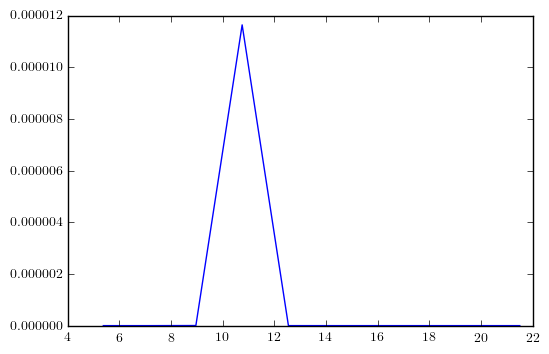

In [512]:
a1_space = a1 * np.linspace(0.5,2, 10)
vals = []
for a1_test in a1_space:
    vals.append(numerical_integration(a1_test,a2,a3,a4,S,nsamples=100))
plt.plot(a1_space, vals)

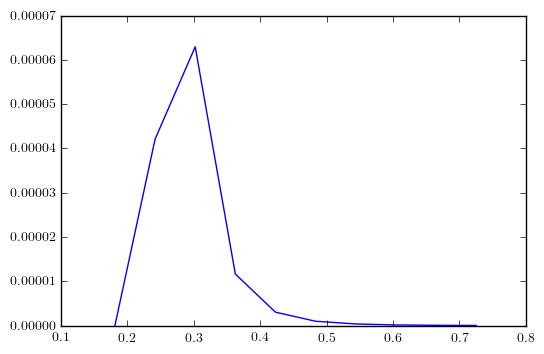

In [517]:
a2_space = a2 * np.linspace(0.5,2, 10)
vals = []
for a2_test in a2_space:
    vals.append(numerical_integration(a1,a2_test,a3,a4,S,nsamples=100))
plt.plot(a2_space, vals)

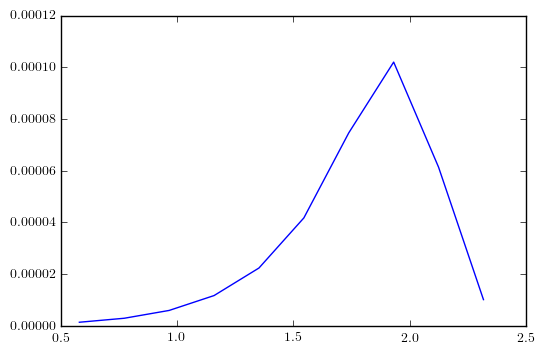

In [515]:
a4_space = a4 * np.linspace(0.5,2, 10)
vals = []
for a4_test in a4_space:
    vals.append(numerical_integration(a1,a2,a3,a4_test,S,nsamples=100))
plt.plot(a4_space, vals)

In [ ]:
a1_space = a1 * np.linspace(0.5,2, 10)
vals = []
for a1_test in a1_space:
    vals.append(numerical_integration(a1_test,a2,a3,a4,S,nsamples=100))
plt.plot(a1_space, vals)

In [37]:
def numerical_integration(a1, a2, a3, a4, S, nsamples=10**3):
    masses = midpoints(prior.fetch(true_z).mass[1:])
    delta_masses = np.diff(prior.fetch(true_z).mass[1:])
    lums_tmp = np.logspace(log10(np.min(data.lum_obs)), log10(np.max(data.lum_obs)), nsamples)
    lums = midpoints(lums_tmp)
    delta_lums = np.diff(lums_tmp)
    sigma = 0.05
    integral = 0
    for i,lum in enumerate(lums):
        integral += np.sum(delta_masses * delta_lums[i] * p1(true_lum_obs, lum, sigma) * \
            p2(lum, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z))
    return integral

In [536]:
nsamples = 100
masses = midpoints(prior.fetch(true_z).mass[1:])
delta_masses = np.diff(prior.fetch(true_z).mass[1:])
lums_tmp = np.logspace(log10(np.min(data.lum_obs)), log10(np.max(data.lum_obs)), nsamples)
lums = midpoints(lums_tmp)
delta_lums = np.diff(lums_tmp)
sigma = 0.05

def func(params):
    a1,a2,a4,S = params
    integral = 0
    for i,lum in enumerate(lums):
        integral += np.sum(delta_masses * delta_lums[i] * p1(true_lum_obs, lum, sigma) * \
            p2(lum, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z))
    return -integral
x0 = [a1,a2,a4,S*5]
obj = minimize(func, x0, method='BFGS')

In [546]:
obj['x']

array([  1.07368855e+01,   2.89190866e-01,   1.14645141e+00,
         6.23726598e-05])

In [430]:
%time print numerical_integration(a1,a2,a3,a4,S, nsamples=10**3)

1.16445252492e-05
CPU times: user 156 ms, sys: 4.52 ms, total: 161 ms
Wall time: 203 ms


In [427]:
%time print numerical_integration(a1,a2,a3,a4,S, nsamples=10**2)

1.16423505533e-05
CPU times: user 15.8 ms, sys: 1.21 ms, total: 17 ms
Wall time: 15.7 ms


In [428]:
%time print numerical_integration(a1,a2,a3,a4,S, nsamples=10**4)

1.16445466074e-05
CPU times: user 1.29 s, sys: 12.2 ms, total: 1.3 s
Wall time: 1.31 s


In [156]:
def numerical_integration(a1, a2, a3, a4, S, nsamples=10**4):
    masses = midpoints(prior.fetch(true_z).mass)
    delta_masses = np.diff(prior.fetch(true_z).mass)
    lums = np.linspace(np.min(data.lum_obs), np.max(data.lum_obs), nsamples)
    print nsamples
    delta_lum = lums[1] - lums[0]
    print delta_lum
    sigma = 0.05
    integral = 0
    for lum in lums:
        integral += np.sum(delta_masses * delta_lum * p1(true_lum_obs, lum, sigma) * \
            p2(lum, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z))
    return integral

In [157]:
%time print numerical_integration(a1,a2,a3,a4,S, nsamples=10**5)

100000
1.09545583084
1.16445468227e-05
CPU times: user 12.5 s, sys: 45.8 ms, total: 12.5 s
Wall time: 12.6 s


In [158]:
%time print numerical_integration(a1,a2,a3,a4,S, nsamples=10**4)

10000
10.9555443173
1.16445468227e-05
CPU times: user 1.29 s, sys: 6.5 ms, total: 1.3 s
Wall time: 1.3 s


In [155]:
%time print numerical_integration(a1,a2,a3,a4,S, nsamples=10**3)

1.16445468227e-05
CPU times: user 146 ms, sys: 1.94 ms, total: 148 ms
Wall time: 148 ms


In [151]:
%time print numerical_integration(a1,a2,a3,a4,S, nsamples=10**6)

0.00112456109124
CPU times: user 2min 5s, sys: 431 ms, total: 2min 5s
Wall time: 2min 6s


In [143]:
n = 10
vals = np.zeros(n)
timevals = np.zeros(n)
logspace = np.logspace(2, 5, n)
for i, nsamples in enumerate(logspace):
    start = time.time()
    vals[i] = numerical_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    end = time.time()
    timevals[i] = end - start

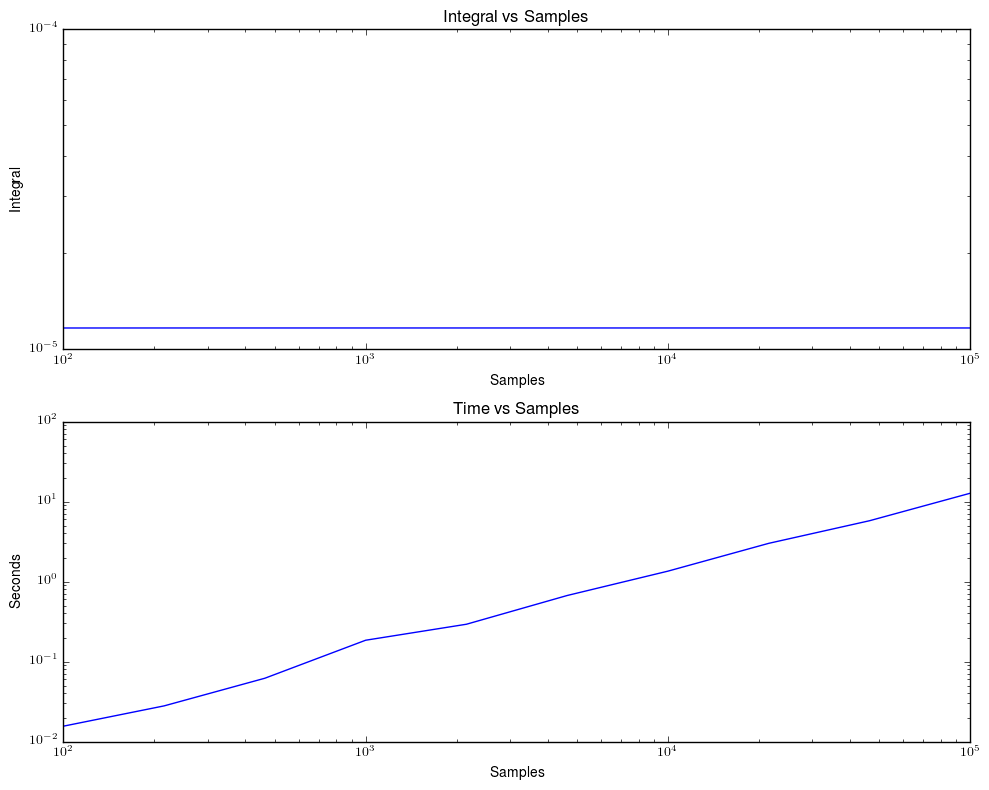

In [144]:
plt.subplot(211)
plt.plot(logspace, vals)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Integral vs Samples')
plt.xlabel('Samples')
plt.ylabel('Integral')

plt.subplot(212)
plt.plot(logspace, timevals)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Time vs Samples')
plt.xlabel('Samples')
plt.ylabel('Seconds')
plt.gcf().set_size_inches(10,8)
plt.tight_layout()

# Simple Monte Carlo

\begin{align*}
\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs}) &= \iint dLdM\ P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)\\
&= \frac{1}{N_s}\sum_{M \in\ P(M|z)}\sum_{L \in\ P(L|M, \alpha, S, z)} P(L_{obs}|L, \sigma_{obs})\\
\end{align*}

In [3]:
def simple_monte_carlo_integration(a1, a2, a3, a4, S, nsamples=10**6):
    sigma = 0.05
    masses = prior.fetch(true_z).rvs(nsamples)
    mu_lum = np.exp(a1) * ((masses / a3) ** a2) * ((1 + true_z) ** (a4))
    lums = lognorm(S, scale=mu_lum).rvs()
    return np.sum(p1(true_lum_obs, lums, sigma)) / (nsamples)

In [555]:
%time print simple_monte_carlo_integration(a1,a2,a3,a4,S, nsamples=10**4)

1.69121809651e-06
CPU times: user 4.52 ms, sys: 1.36 ms, total: 5.88 ms
Wall time: 4.69 ms


In [556]:
%time print simple_monte_carlo_integration(a1,a2,a3,a4,S, nsamples=10**6)

1.70034874254e-06
CPU times: user 220 ms, sys: 46.5 ms, total: 266 ms
Wall time: 273 ms


In [557]:
%time print simple_monte_carlo_integration(a1,a2,a3,a4,S, nsamples=10**7)

1.69751972983e-06
CPU times: user 2.05 s, sys: 373 ms, total: 2.42 s
Wall time: 2.48 s


In [17]:
import time

n = 20
vals = np.zeros(n)
logspace = np.logspace(4, 7, n)
for i, nsamples in enumerate(logspace):
    vals[i] = simple_monte_carlo_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    
timevals = np.zeros(n)
logspace = np.logspace(4, 7, n)
for i, nsamples in enumerate(logspace):
    start = time.time()
    simple_monte_carlo_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    end = time.time()
    timevals[i] = end - start

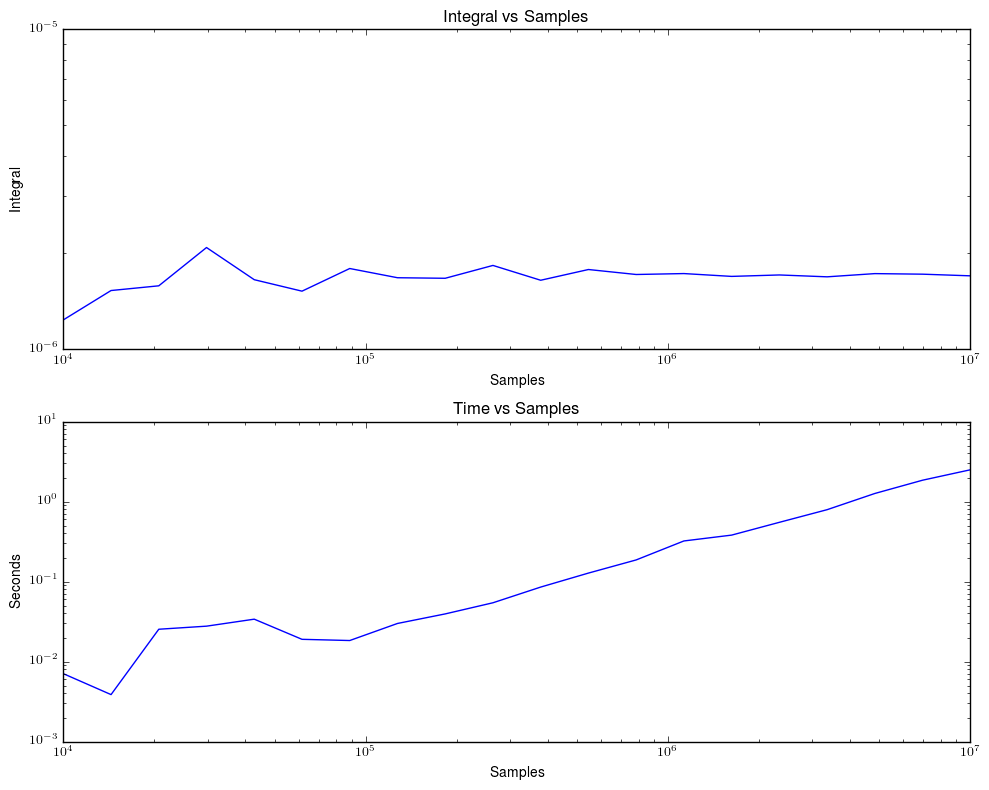

In [20]:
plt.subplot(211)
plt.plot(logspace, vals)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Integral vs Samples')
plt.xlabel('Samples')
plt.ylabel('Integral')

plt.subplot(212)
plt.plot(logspace, timevals)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Time vs Samples')
plt.xlabel('Samples')
plt.ylabel('Seconds')
plt.gcf().set_size_inches(10,8)
plt.tight_layout()

In [4]:
def simple_monte_carlo_integration_samples(a1, a2, a3, a4, S, nsamples=10**6):
    sigma = 0.05
    masses = prior.fetch(true_z).rvs(nsamples)
    mu_lum = np.exp(a1) * ((masses / a3) ** a2) * ((1 + true_z) ** (a4))
    lums = lognorm(S, scale=mu_lum).rvs()
    weights = p1(true_lum_obs, lums, sigma)
    return masses, lums, weights

In [145]:
m, l, w = simple_monte_carlo_integration_samples(a1, a2, a3, a4, S, nsamples=10**6)

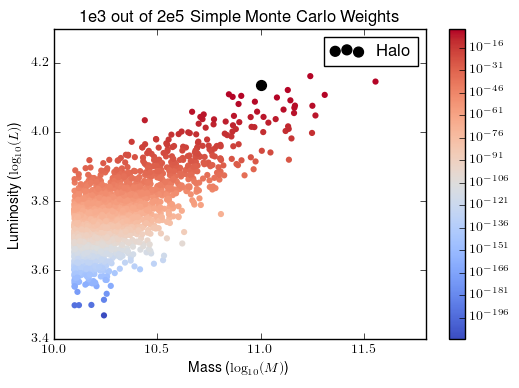

In [160]:
import matplotlib.colors as colors

scat = plt.scatter(log10(m[:2000]), log10(l[:2000]), c=w[:2000], norm=colors.LogNorm(), cmap='coolwarm', lw=0)
plt.gcf().colorbar(scat)
plt.scatter(log10(true_mass), log10(true_lum_obs), color='black', s=50, label='Halo')
plt.legend()
plt.title('1e3 out of 2e5 Simple Monte Carlo Weights')
plt.xlabel('Mass ($\log_{10}(M)$)')
plt.ylabel('Luminosity ($\log_{10}(L)$)')
# step = 1
# epsilon = 1e-20
# gridv = np.maximum(grid[::step,2], epsilon)
# x = log10(grid[::step,0])
# y = log10(grid[::step,1])
# scat = plt.scatter(x, y, marker='s', s=40, alpha=0.8, c=gridv, norm=colors.LogNorm(), cmap='coolwarm', lw=0);
# plt.gcf().set_size_inches((6,6))
# plt.xlim([x.min(),x.max()])
# plt.ylim([y.min(),y.max()])
# plt.scatter(log10(true_lum_obs), log10(true_mass), color='black', s=50, label='True Observed')
# plt.scatter(x[22723], y[22723], color='gold', s=50, label='MaximumWeight')
# plt.legend()
# plt.gcf().colorbar(scat)
# plt.title('Numerical Integration Weights')
# plt.ylabel('Mass $(\log_{10}(M))$')
# plt.xlabel('Luminosity $(\log_{10}(L))$')

# Importance Sampling Integration

In [133]:
import time

n = 20
vals = np.zeros(n)
logspace = np.logspace(3, 6, n)
for i, nsamples in enumerate(logspace):
    vals[i] = importance_sampling_integration(a1,a2,a3,a4,S, nsamples=int(nsamples))
    
timevals = np.zeros(n)
logspace = np.logspace(3, 6, n)
for i, nsamples in enumerate(logspace):
    start = time.time()
    importance_sampling_integration(a1,a2,a3,a4,S, nsamples=int(nsamples))
    end = time.time()
    timevals[i] = end - start

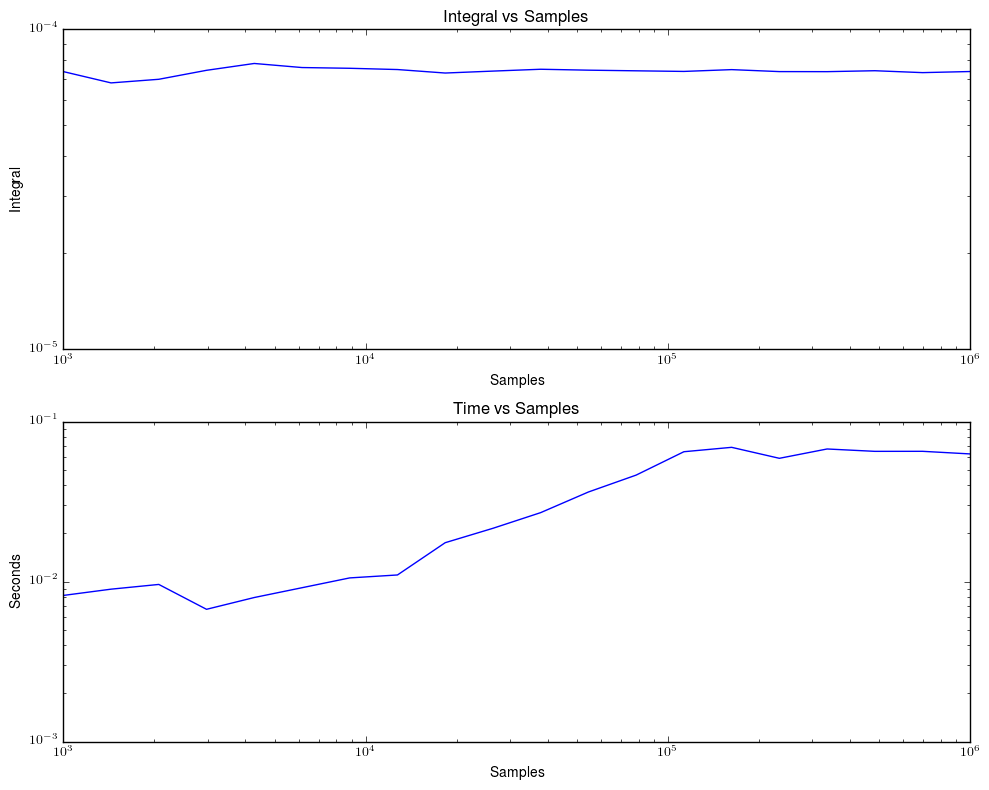

In [134]:
plt.subplot(211)
plt.plot(logspace, vals)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Integral vs Samples')
plt.xlabel('Samples')
plt.ylabel('Integral')

plt.subplot(212)
plt.plot(logspace, timevals)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Time vs Samples')
plt.xlabel('Samples')
plt.ylabel('Seconds')
plt.gcf().set_size_inches(10,8)
plt.tight_layout()

\begin{align*}
\mathcal{L}(L_{obs}|\alpha_1, \alpha_2, \alpha_3, \alpha_4, S, \sigma_{obs}) &= \iint \frac{P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)Q(M,L)}{Q(M,L)}\\
&= \frac{1}{N_s}\sum_{(M,L) \in\ Q}\frac{P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)}{Q(L|L_{obs}, \sigma_{obs})Q(M|L,\alpha, S, z, c)}\\
\end{align*}

In [132]:
def importance_sampling_integration(a1, a2, a3, a4, S, nsamples=10**6):
    nsamples = min(nsamples, len(true_lum_obs_collection)-1)
    sigma = 0.05
    rev_S = 5.6578015811698101 * S
    permuted_lum_obs = np.random.permutation(true_lum_obs_collection)[:nsamples]
    lums = lognorm(sigma, scale=permuted_lum_obs).rvs()
    mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    masses = lognorm(rev_S, scale=mu_mass).rvs()
    integral = np.sum((p1(permuted_lum_obs, lums, sigma) * \
            p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)) / \
                (q1(lums, permuted_lum_obs, sigma) * q2(masses, lums, a1, a2, a3, a4, rev_S, true_z))) /\
            len(lums)
    return integral

In [560]:
%time print importance_sampling_integration(a1,a2,a3,a4,S, nsamples=10**2)

0.000131549976458
CPU times: user 6.51 ms, sys: 1.22 ms, total: 7.73 ms
Wall time: 6.62 ms


In [559]:
%time print importance_sampling_integration(a1,a2,a3,a4,S, nsamples=10**3)

0.000136712311576
CPU times: user 7.64 ms, sys: 2.45 ms, total: 10.1 ms
Wall time: 8.45 ms


In [121]:
%time print importance_sampling_integration(a1,a2,a3,a4,S, nsamples=10**4)

0.000137747326398
CPU times: user 12.3 ms, sys: 1.82 ms, total: 14.1 ms
Wall time: 12.7 ms


In [122]:
%time print importance_sampling_integration(a1,a2,a3,a4,S, nsamples=10**7)

0.000133224486982
CPU times: user 80.2 ms, sys: 7.46 ms, total: 87.6 ms
Wall time: 86.1 ms


In [123]:
%time print importance_sampling_integration(a1,a2,a3,a4,S, nsamples=10**8)

0.000133246748158
CPU times: user 89.5 ms, sys: 5.96 ms, total: 95.4 ms
Wall time: 95.7 ms


In [13]:
def importance_sampling_integration_samples(a1, a2, a3, a4, S, nsamples=10**6):
    nsamples = min(nsamples, len(true_lum_obs_collection)-1)
    sigma = 0.05
    rev_S = 5.6578015811698101 * S
    permuted_lum_obs = np.random.permutation(true_lum_obs_collection)[:nsamples]
    lums = lognorm(sigma, scale=permuted_lum_obs).rvs()
    mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    masses = lognorm(rev_S, scale=mu_mass).rvs()
    weights = (p1(permuted_lum_obs, lums, sigma) * \
            p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)) / \
                (q1(lums, permuted_lum_obs, sigma) * q2(masses, lums, a1, a2, a3, a4, rev_S, true_z))
    return masses, lums, weights

In [161]:
m, l, w = importance_sampling_integration_samples(a1, a2, a3, a4, S, nsamples=10**6)

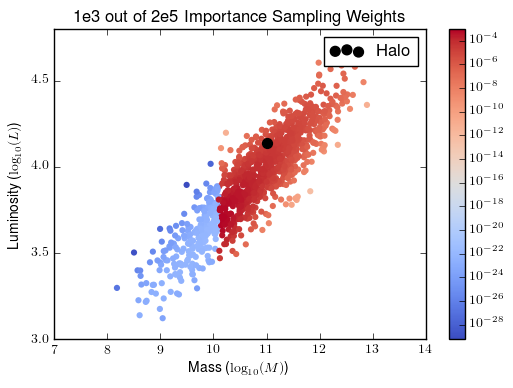

In [163]:
import matplotlib.colors as colors
scat = plt.scatter(log10(m[:1000]), log10(l[:1000]), c=w[:1000], norm=colors.LogNorm(), cmap='coolwarm', lw=0)
plt.gcf().colorbar(scat)
plt.scatter(log10(true_mass), log10(true_lum_obs), color='black', s=50, label='Halo')
plt.legend()
plt.title('1e3 out of 2e5 Importance Sampling Weights')
plt.xlabel('Mass ($\log_{10}(M)$)')
plt.ylabel('Luminosity ($\log_{10}(L)$)')

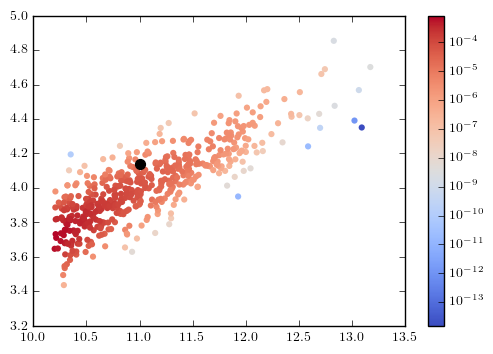

In [18]:
import matplotlib.colors as colors
ind = log10(m) > 10.2
scat = plt.scatter(log10(m[ind][:500]), log10(l[ind][:500]), c=w[ind][:500], norm=colors.LogNorm(), cmap='coolwarm', lw=0)
plt.gcf().colorbar(scat)
plt.scatter(log10(true_mass), log10(true_lum_obs), color='black', s=50, label='True Observed')
# step = 1
# epsilon = 1e-20
# gridv = np.maximum(grid[::step,2], epsilon)
# x = log10(grid[::step,0])
# y = log10(grid[::step,1])
# scat = plt.scatter(x, y, marker='s', s=40, alpha=0.8, c=gridv, norm=colors.LogNorm(), cmap='coolwarm', lw=0);
# plt.gcf().set_size_inches((6,6))
# plt.xlim([x.min(),x.max()])
# plt.ylim([y.min(),y.max()])
# plt.scatter(log10(true_lum_obs), log10(true_mass), color='black', s=50, label='True Observed')
# plt.scatter(x[22723], y[22723], color='gold', s=50, label='MaximumWeight')
# plt.legend()
# plt.gcf().colorbar(scat)
# plt.title('Numerical Integration Weights')
# plt.ylabel('Mass $(\log_{10}(M))$')
# plt.xlabel('Luminosity $(\log_{10}(L))$')

In [20]:
prior.fetch(2.0).pdf(10**10.2)

5.01830539050561e-11

In [22]:
prior.fetch(2.0).pdf(10**12)

9.3433202778941481e-15

In [23]:
def importance_sampling_integration_samples2(a1, a2, a3, a4, S, nsamples=10**6):
    nsamples = min(nsamples, len(true_lum_obs_collection)-1)
    sigma = 0.05
    rev_S = 5.6578015811698101 * S
    permuted_lum_obs = np.random.permutation(true_lum_obs_collection)[:nsamples]
    lums = lognorm(sigma, scale=permuted_lum_obs).rvs()
    mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    masses = lognorm(rev_S, scale=mu_mass).rvs()
    return masses, lums, p2(lums, masses, a1, a2, a3, a4, S, true_z), q2(masses, lums, a1, a2, a3, a4, rev_S, true_z)

In [110]:
m, l, wn, wd = importance_sampling_integration_samples2(a1, a2, a3, a4, S, nsamples=10**6)

In [111]:
print np.sum(log10(m) < 10.2)
print np.sum(log10(m) > 10.2)

28753
87165


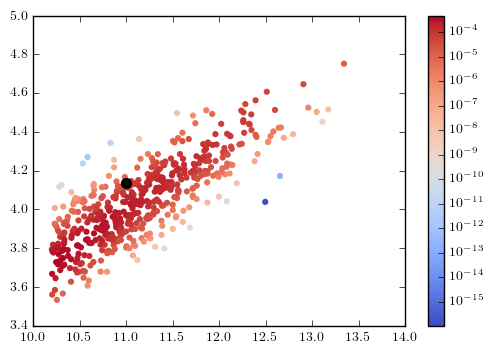

In [25]:
import matplotlib.colors as colors
ind = log10(m) > 10.2
scat = plt.scatter(log10(m[ind][:500]), log10(l[ind][:500]), c=wn[ind][:500], norm=colors.LogNorm(), cmap='coolwarm', lw=0)
plt.gcf().colorbar(scat)
plt.scatter(log10(true_mass), log10(true_lum_obs), color='black', s=50, label='True Observed')

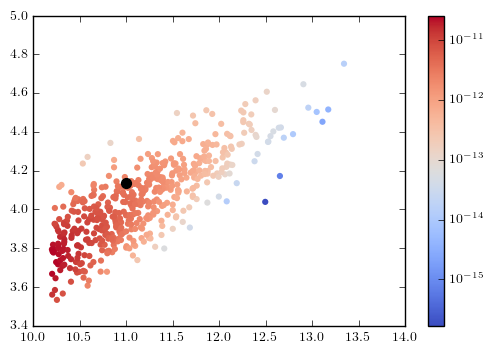

In [26]:
ind = log10(m) > 10.2
scat = plt.scatter(log10(m[ind][:500]), log10(l[ind][:500]), c=wd[ind][:500], norm=colors.LogNorm(), cmap='coolwarm', lw=0)
plt.gcf().colorbar(scat)
plt.scatter(log10(true_mass), log10(true_lum_obs), color='black', s=50, label='True Observed')

In [29]:
from scipy.optimize import minimize

def func(prms):
    a1, a2, a4, S = prms
    nsamples = len(true_lum_obs_collection)-1
    sigma = 0.05
    rev_S = 5.6578015811698101 * S
    permuted_lum_obs = np.random.permutation(true_lum_obs_collection)[:nsamples]
    lums = lognorm(sigma, scale=permuted_lum_obs).rvs()
    mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    masses = lognorm(rev_S, scale=mu_mass).rvs()
    integral = np.sum((p1(permuted_lum_obs, lums, sigma) * \
            p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)) / \
                (q1(lums, permuted_lum_obs, sigma) * q2(masses, lums, a1, a2, a3, a4, rev_S, true_z))) /\
            len(lums)
    return -integral

x0 = [a1,a2,a4,S]

obj = minimize(func, x0, method='BFGS')

/usr/local/lib/python2.7/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


In [30]:
obj

      fun: -7.4760615596372037e-05
 hess_inv: array([[  3.48308698e-07,  -2.07882698e-07,  -7.73768703e-08,
         -2.54135667e-07],
       [ -2.07882697e-07,   1.24347463e-07,   4.59867788e-08,
          1.50790041e-07],
       [ -7.73768700e-08,   4.59867783e-08,   1.73287045e-08,
          5.70702805e-08],
       [ -2.54135669e-07,   1.50790043e-07,   5.70702803e-08,
          1.88342460e-07]])
      jac: array([-28.30590744, -24.68470101,  41.00275193, -11.44276151])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 342
      nit: 6
     njev: 52
   status: 2
  success: False
        x: array([ 10.74781344,   0.36260134,   1.1587271 ,   0.15702342])

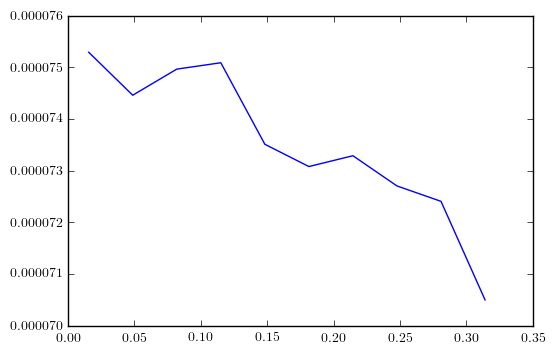

In [40]:
S_space = S * np.linspace(0.1,2, 10)
vals = []
for S_test in S_space:
    vals.append(importance_sampling_integration(a1,a2,a3,a4,S_test,nsamples=10**5))
plt.plot(S_space, vals)

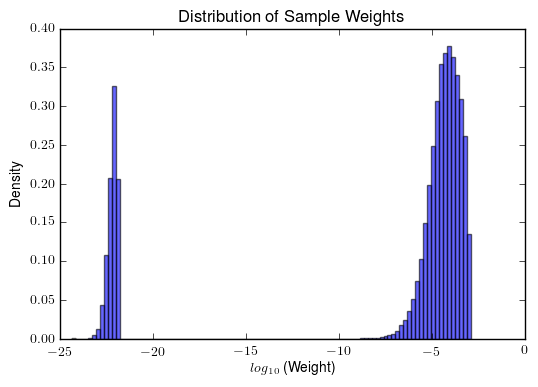

In [129]:
samples = importance_sampling_integration_samples(a1,a2,a3,a4,S, nsamples=10**5)
plt.title('Distribution of Sample Weights')
plt.ylabel('Density')
plt.xlabel('$log_{10}$\ (Weight)')
plt.hist(np.log(samples)/np.log(10), alpha=0.6, bins=100, normed=True);

In [132]:
samples.max()

0.0013192080292059318

In [140]:
nsamples = min(nsamples, len(true_lum_obs_collection)-1)
sigma = 0.05
rev_S = 5.6578015811698101 * S
permuted_lum_obs = np.random.permutation(true_lum_obs_collection)[:nsamples]
lums = lognorm(sigma, scale=permuted_lum_obs).rvs()
mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
masses = lognorm(rev_S, scale=mu_mass).rvs()
tp1 = p1(permuted_lum_obs, lums, sigma)
tp2 = p2(lums, masses, a1, a2, a3, a4, S, true_z)
tp3 = p3(masses, true_z)
tq1 = q1(lums, permuted_lum_obs, sigma)
tq2 = q2(masses, lums, a1, a2, a3, a4, rev_S, true_z)

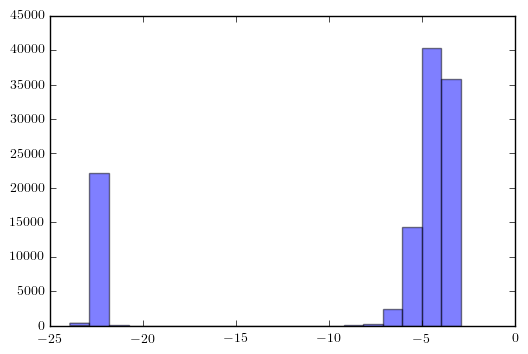

In [145]:
plt.hist(log10((tp2 * tp3) / tq2), bins=20, alpha=0.5);

In [107]:
np.argmax(tp2 * tp3 / tq2)

36661

In [110]:
print tp2[36661]
print tp3[36661]
print tq2[36661]

9.02349891243e-06
4.59164464371e-11
3.57647859837e-25


In [7]:
def log10(a):
    return np.log(a) / np.log(10)

In [119]:
log10(mu_mass[36661])

9.6630631262198872

In [117]:
log10(lums[36661])

3.5262049285569601

In [113]:
log10(masses[36661])

10.222765044465945

(array([  3.30000000e+01,   2.62000000e+02,   8.21000000e+02,
          2.16700000e+03,   4.30800000e+03,   7.13600000e+03,
          1.00680000e+04,   1.29990000e+04,   1.57350000e+04,
          1.74310000e+04,   1.70490000e+04,   1.30900000e+04,
          7.97200000e+03,   4.01100000e+03,   1.81200000e+03,
          7.08000000e+02,   2.25000000e+02,   6.20000000e+01,
          2.30000000e+01,   6.00000000e+00]),
 array([  8.13542481,   8.42363065,   8.71183649,   9.00004233,
          9.28824817,   9.57645401,   9.86465985,  10.15286569,
         10.44107153,  10.72927737,  11.01748321,  11.30568905,
         11.59389489,  11.88210074,  12.17030658,  12.45851242,
         12.74671826,  13.0349241 ,  13.32312994,  13.61133578,  13.89954162]),
 <a list of 20 Patch objects>)

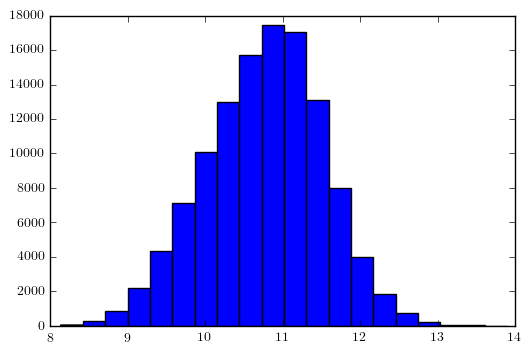

In [38]:
plt.hist(np.log(masses)/np.log(10), bins=20)

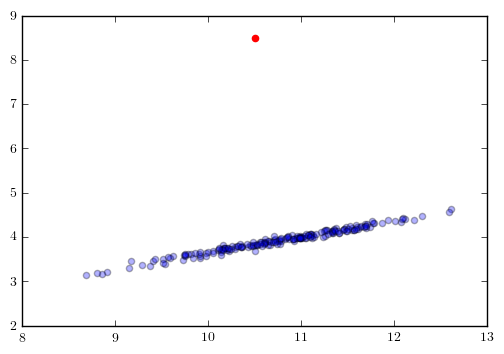

In [58]:
plt.scatter(10.50, 8.49, color='red')
plt.scatter(10.50, 8.49, color='green')
plt.scatter(np.log(masses[:200]) / np.log(10), np.log(lums[:200]) / np.log(10), alpha=0.3)

In [50]:
np.log(masses[6]) / np.log(10)

10.50309270355808

In [51]:
np.log(lums[6])

8.4971594894965126

In [59]:
permuted_lum_obs[6]

5138.5754516699999

In [65]:
permuted_lum_obs = np.random.permutation(true_lum_obs_collection)[:nsamples]
lums = lognorm(sigma, scale=permuted_lum_obs).rvs()

(array([  1.40000000e+01,   2.25000000e+02,   8.28000000e+02,
          2.06000000e+03,   4.20400000e+03,   7.03500000e+03,
          9.88100000e+03,   1.28850000e+04,   1.56210000e+04,
          1.78170000e+04,   1.72810000e+04,   1.33680000e+04,
          8.02000000e+03,   3.96600000e+03,   1.72300000e+03,
          6.86000000e+02,   2.23000000e+02,   5.60000000e+01,
          2.00000000e+01,   5.00000000e+00]),
 array([ 2.97311334,  3.07722739,  3.18134144,  3.28545549,  3.38956954,
         3.49368359,  3.59779764,  3.70191169,  3.80602574,  3.91013979,
         4.01425383,  4.11836788,  4.22248193,  4.32659598,  4.43071003,
         4.53482408,  4.63893813,  4.74305218,  4.84716623,  4.95128028,
         5.05539432]),
 <a list of 20 Patch objects>)

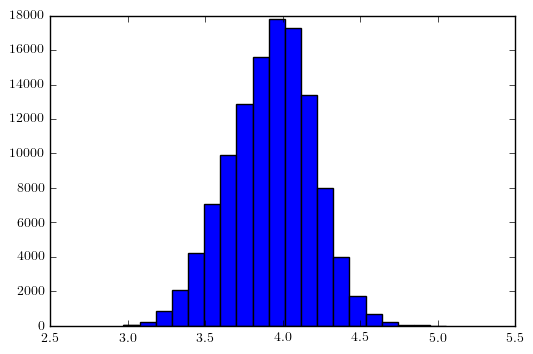

In [66]:
plt.hist(np.log(lums) / np.log(10), bins=20)

In [68]:
lums.max()

113604.18340356463

In [69]:
np.log(lums.max()) / np.log(10)

5.0553943242942907

# Optimization

In [198]:
from scipy.optimize import minimize

ans = np.array([a1,a2,a3,a4,S])
def func(arr):
    return - importance_sampling_integration(*(arr * ans))

x0 = np.array([1,0.97,1.01,1.03,1.2])
minimize(func, x0, method='Nelder-Mead')

      fun: -0.00013042002983643667
 hess_inv: array([[ 0.68012823, -0.20927487, -0.13289837, -0.26835587, -0.29565279],
       [-0.20927487,  0.87743721, -0.07796555, -0.17923977, -0.18053777],
       [-0.13289837, -0.07796555,  0.95040535, -0.11379082, -0.11476855],
       [-0.26835587, -0.17923977, -0.11379082,  0.77580109, -0.25133255],
       [-0.29565279, -0.18053777, -0.11476855, -0.25133255,  0.73831085]])
      jac: array([-43.99549979, -16.55729911, -10.6278869 , -40.03504741, -29.68355597])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 201
      nit: 1
     njev: 27
   status: 2
  success: False
        x: array([ 1.  ,  0.97,  1.01,  1.03,  1.2 ])

In [183]:
[a1,a2,a3,a4,S]

[10.747809151611289,
 0.36260141487530501,
 235000000000000.0,
 1.1587242790463443,
 0.1570168038792813]

# Plots

In [178]:
np.append([2,5], np.logspace(1, 5, n))

array([  2.00000000e+00,   5.00000000e+00,   1.00000000e+01,
         1.62377674e+01,   2.63665090e+01,   4.28133240e+01,
         6.95192796e+01,   1.12883789e+02,   1.83298071e+02,
         2.97635144e+02,   4.83293024e+02,   7.84759970e+02,
         1.27427499e+03,   2.06913808e+03,   3.35981829e+03,
         5.45559478e+03,   8.85866790e+03,   1.43844989e+04,
         2.33572147e+04,   3.79269019e+04,   6.15848211e+04,
         1.00000000e+05])

In [183]:
n = 15
vals = np.zeros((n+1, 3))
timevals = np.zeros((n+1, 3))
logspace = np.append([5], np.logspace(1, 5, n))
for i, nsamples in enumerate(logspace):
    nsamples = int(nsamples)
    start = time.time()
    vals[i][0] = numerical_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    end = time.time()
    timevals[i][0] = end - start
    
    start = time.time()
    vals[i][1] = simple_monte_carlo_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    end = time.time()
    timevals[i][1] = end - start
    
    start = time.time()
    vals[i][2] = importance_sampling_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    end = time.time()
    timevals[i][2] = end - start

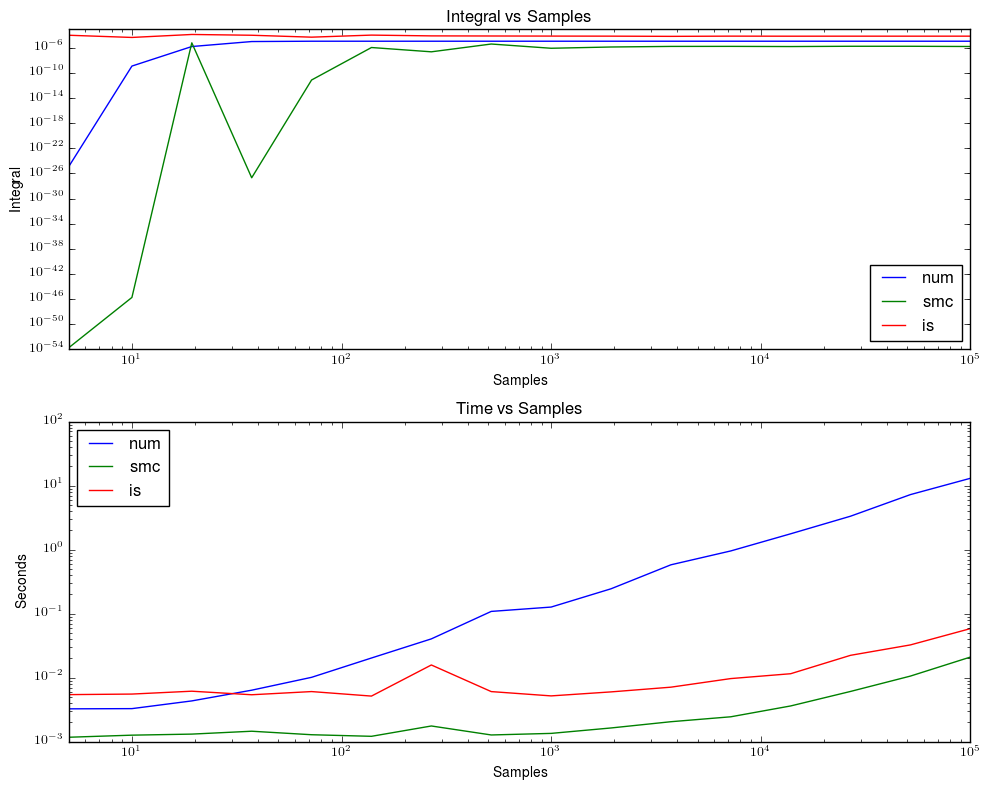

In [185]:
plt.subplot(211)
plt.plot(logspace, vals[:,0], label='num')
plt.plot(logspace, vals[:,1], label='smc')
plt.plot(logspace, vals[:,2], label='is')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Integral vs Samples')
plt.xlabel('Samples')
plt.ylabel('Integral')
plt.xlim([5,10**5])
plt.legend(loc=4)

plt.subplot(212)
plt.plot(logspace, timevals[:,0], label='num')
plt.plot(logspace, timevals[:,1], label='smc')
plt.plot(logspace, timevals[:,2], label='is')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Time vs Samples')
plt.xlabel('Samples')
plt.ylabel('Seconds')
plt.legend(loc=2)
plt.xlim([5,10**5])

plt.gcf().set_size_inches(10,8)
plt.tight_layout();

In [186]:
def numerical_integration_linear(a1, a2, a3, a4, S, nsamples=10**3):
    masses = midpoints(prior.fetch(true_z).mass[1:])
    delta_masses = np.diff(prior.fetch(true_z).mass[1:])
    lums_tmp = np.linspace(np.min(data.lum_obs), np.max(data.lum_obs), nsamples)
    lums = midpoints(lums_tmp)
    delta_lums = np.diff(lums_tmp)
    sigma = 0.05
    integral = 0
    for i,lum in enumerate(lums):
        integral += np.sum(delta_masses * delta_lums[i] * p1(true_lum_obs, lum, sigma) * \
            p2(lum, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z))
    return integral

In [188]:
n = 8
vals = np.zeros((n, 2))
timevals = np.zeros((n, 2))
logspace = np.logspace(1, 5, n)
for i, nsamples in enumerate(logspace):
    nsamples = int(nsamples)
    start = time.time()
    vals[i][0] = numerical_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    end = time.time()
    timevals[i][0] = end - start
    start = time.time()
    vals[i][1] = numerical_integration_linear(a1,a2,a3,a4,S, nsamples=nsamples)
    end = time.time()
    timevals[i][1] = end - start

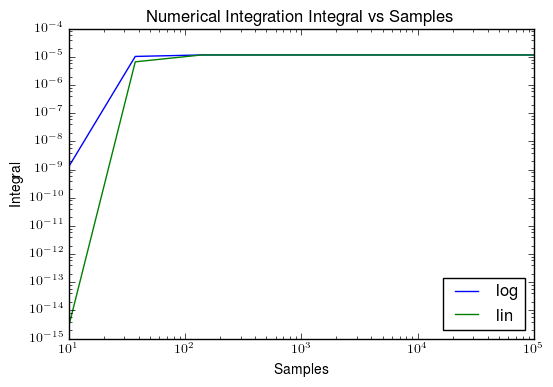

In [191]:
plt.plot(logspace, vals[:,0], label='log')
plt.plot(logspace, vals[:,1], label='lin')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Numerical Integration Integral vs Samples')
plt.xlabel('Samples')
plt.ylabel('Integral')
plt.legend(loc=4)